# Requirements 
python 3.9
Tensorflow 2.10
torch==1.12.1+cu113 

In [ ]:
# !pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
# !pip install openai
# !nvcc --version
# !pip install accelerate


In [1]:
import torch

print("Is CUDA available: ", torch.cuda.is_available())
print("Number of GPUs Available: ", torch.cuda.device_count())
print("Name of the GPU: ", torch.cuda.get_device_name(0))


c:\Users\Rugved Chavan\anaconda3\envs\tf1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Is CUDA available:  True
Number of GPUs Available:  1
Name of the GPU:  NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [2]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Num GPUs Available:  1


In [3]:
# import os
# from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
# import random
# from PIL import Image
# # from transformers import T5ForConditionalGeneration, T5Tokenizer
# from PIL import Image
# import openai

# Load Stable Diffusion

In [3]:
import torch
from diffusers import StableDiffusionPipeline
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler


model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"


scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.enable_attention_slicing()

prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]  
    
image.save("astronaut_rides_horse.png")

100%|██████████| 50/50 [00:08<00:00,  6.21it/s]


# Load the Image to Text lib

In [4]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Loading checkpoint shards: 100%|██████████| 2/2 [00:20<00:00, 10.39s/it]


Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0): Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
        (1): Blip2EncoderLayer(
          (self_attn): 

# Load Auto-classifier

In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import numpy as np

def load_classifier_model():
    # Load the saved model
    model = load_model('my_model.h5')

    # Load the tokenizer
    with open('tokenizer.pkl', 'rb') as handle:
        tokenizer = pickle.load(handle)

    # Load the label encoder
    with open('label_encoder.pkl', 'rb') as handle:
        label_encoder = pickle.load(handle)

    return model, tokenizer, label_encoder

def predict_class(text, model, tokenizer, label_encoder, max_length):
    # Tokenize and pad the input text
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length)

    # Predict
    prediction = model.predict(padded_sequence)
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])

    return predicted_class[0]

# Working Model with No GUI 

c:\Users\Rugved Chavan\anaconda3\envs\tf1\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


--------------------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 45ms/step
Predicted Class for output: Generate Image


100%|██████████| 50/50 [00:06<00:00,  8.28it/s]


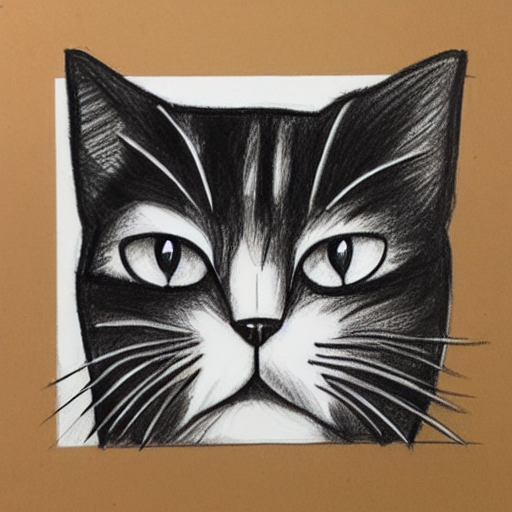

--------------------------------------------------------------------------------------------------------------
Exiting the program.


In [32]:
import tkinter as tk
from tkinter import simpledialog, filedialog
from PIL import Image
import openai  # Assuming you're using OpenAI's GPT models

def handle_text_input():
    text = input("Enter the text or prompt")
    return text

def handle_image_input():
    root = tk.Tk()
    root.withdraw()  # Hide the main window
    image_path = filedialog.askopenfilename(title="Select an Image",
                                            filetypes=[("Image Files", "*.png;*.jpg;*.jpeg;*.bmp;*.gif")])
    root.destroy()

    if image_path:
        try:
            image = Image.open(image_path).convert('RGB')
            resized_image = image.resize((596, 437))
            resized_image.show()  # This will display the image using the default image viewer
            return image
        except IOError:
            print("Could not read the image. Please check the file path.")
    return None

def handle_both_input():
    text_output = handle_text_input()
    image_output = handle_image_input()
    return text_output, image_output

# Global variable for conversation history
conversation_history = []

def generate_text(input_text, history):
    global conversation_history
    openai.api_key = ""
    try:
        # Include conversation history in the prompt
        full_prompt = "/n".join(history) + "/n" + input_text
        response = openai.Completion.create(
          engine="text-davinci-003",
          prompt=full_prompt,
          max_tokens=100
        )
        generated_text = response.choices[0].text.strip()
        # Update conversation history
        conversation_history.extend([input_text, generated_text])
        print(":)")
        return generated_text
    except Exception as e:
        print(f"An error occurred: {e}")
        return ""

def generate_text_from_image(image, prompt):
    if prompt:
        inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
        generated_ids = model.generate(**inputs, max_new_tokens=20)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        return generated_text

    else:
        inputs = processor(image, return_tensors="pt").to(device, torch.float16)
        generated_ids = model.generate(**inputs, max_new_tokens=20)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        return generated_text
    
        
def generate_image(prompt):
    pipe.enable_attention_slicing()
    image = pipe(prompt).images[0]
    display(image)
    return image

def random_output_decision(text_input, resized_image, model, tokenizer, label_encoder, max_length):
    global conversation_history
    
    # Predict the output format using the classifier
    predicted_class = predict_class(text_input if text_input else "Default text", model, tokenizer, label_encoder, max_length)
    print("Predicted Class for output:", predicted_class)

    decision = predicted_class  # 'text', 'image', or 'both'


    if decision == 'Generate Text':
        if resized_image is None:
            # Concatenate history and text_input into a single string
            full_text_input = "/n".join(conversation_history) + "/nQuestion: " + (text_input or "Default text") + " Answer:"
            text2 = ''
            print(generate_text(full_text_input, conversation_history))
            
        elif text_input == None:
            value = generate_text_from_image(resized_image, None)
            text2 = generate_text_from_image(resized_image, "this is a image of")
            text1 = str("Correct the answer by adding more details. Give me complete answer." + str(text_input) + " This is a image of" + str(text2) + str(value))
            value_exp = generate_text(text1, conversation_history)
            print("Answer: " +  value + value_exp)

        else:
            value = generate_text_from_image(resized_image, text_input)
            text2 = generate_text_from_image(resized_image, "this is a image of")
            text1 = str("Correct the answer by adding more details. Give me complete answer." + str(text_input) + " This is a image of" + str(text2) + str(value))
            value_exp = generate_text(text1, conversation_history)
            print("Answer: " +  value + value_exp)
        

    elif decision == 'Generate Image':
        history_str = "/n".join(conversation_history)

        if resized_image == None:
            # value = generate_text(text_input if text_input is not None else "Default text")
            value = text_input

        elif text_input == None:
            value = generate_text_from_image(resized_image, None)

        else:
            value = generate_text_from_image(resized_image, text_input)

        image_output = generate_image(value)


    elif decision == 'Generate Both':
        history_str = "/n".join(conversation_history)
        
        if resized_image is None:
            value = generate_text(text_input if text_input is not None else "Default text", conversation_history)
            text2 = "Stable diffusion has created the image."

        elif text_input is None:
            value = generate_text_from_image(resized_image, None)
            text2 = generate_text_from_image(resized_image, "this is a image of")

        else:
            value = generate_text_from_image(resized_image, text_input)
            text2 = generate_text_from_image(resized_image, "this is a image of")

        
        text1 = "Correct the answer by adding more details. Give me complete answer. " + str(text_input) + " " + str(text2) + " " + str(value)
        value_exp = generate_text(text1, conversation_history)
        print("Answer: " + value + value_exp)
        input_comb = "Description: " + str(value) + str(value_exp)
        image_output = generate_image(input_comb[:77])

def main():
    # Load the model and components
    model1, tokenizer, label_encoder = load_classifier_model()

    max_length = 150  # Replace with the actual max length used during training

    try:
        while True:
            print("--------------------------------------------------------------------------------------------------------------")
            choice = input("Enter 'text' for text input, 'image' for image input, 'both' for both, or 'exit' to quit: ").lower()

            if choice == 'exit':
                print("Exiting the program.")
                break

            elif choice == 'text':
                text_output = handle_text_input()
                random_output_decision(text_output, None, model1, tokenizer, label_encoder, max_length)

            elif choice == 'image':
                image = handle_image_input()
                if image is not None:
                    random_output_decision(None, image, model1, tokenizer, label_encoder, max_length)

            elif choice == 'both':
                text_input, image = handle_both_input()
                if text_input is not None and image is not None:
                    random_output_decision(text_input, image, model1, tokenizer, label_encoder, max_length)

            else:
                print("Invalid input. Please choose 'text', 'image', 'both', or 'exit'.")

    finally:
        # Delete large objects and free up memory
        del tokenizer
        del label_encoder
        conversation_history = ""
        import gc
        gc.collect()

if __name__ == "__main__":
    main()


# Working Model With GUI

c:\Users\Rugved Chavan\anaconda3\envs\tf1\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


--------------------------------------------------------------------------------------------------------------
Prompt: Describe the dish in the provided image, including potential ingredients
and floavors.


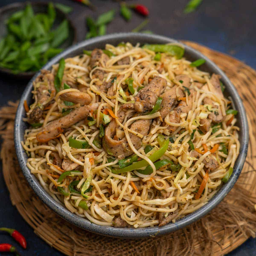

1/1 [==============================] - 0s 48ms/step
Predicted Class for output: Generate Text
:)
Answer: .  This bowl of noodles is a delicious and comforting dish. It is likely made
with noodles such as ramen, udon, spaghetti, or risoni. The savory broth is made
with a combination of vegetables, meats (possibly pork, chicken, beef, or tofu)
and flavorful seasonings like garlic, ginger, and soy sauce. The ingredients
then cooked together in a rich broth with vegetables, including carrots, onion,
bell pepper, and mushrooms. The vegetables add a substantial
--------------------------------------------------------------------------------------------------------------
Prompt: how can i make the noodles healthy? explain me with both image and text?
1/1 [==============================] - 0s 13ms/step
Predicted Class for output: Generate Both
:)
:)
Answer: You can make your bowl of noodles more healthy by swapping out processed noodles
such as ramen or udon noodles, for healthier alternatives

100%|██████████| 50/50 [00:06<00:00,  7.83it/s]


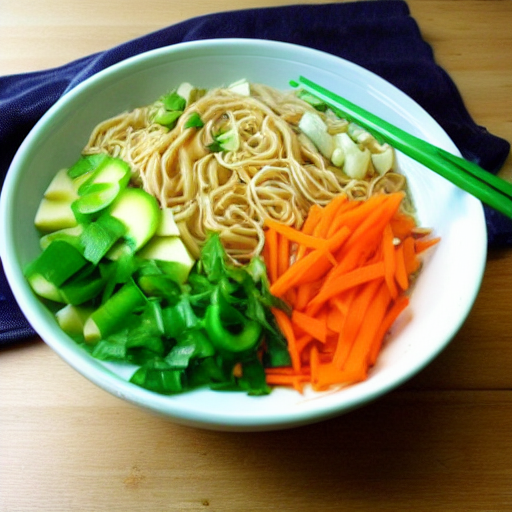

--------------------------------------------------------------------------------------------------------------
Prompt: what is the kid holding in his hand?


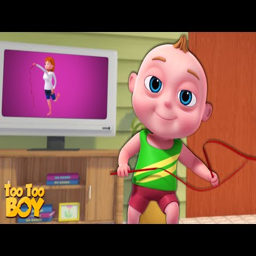

1/1 [==============================] - 0s 14ms/step
Predicted Class for output: Generate Text
:)
Answer: | too to boy | kids tv | cartoonexplain by providing an answer  The child in the image is holding a rope in
their hands. They appear to be playing with the rope, possibly pretending to
swing on it. The rope is likely a toy, made from soft and flexible material for
safety purposes. Depending on the age of the child, the rope could also be a
part of a larger toy such as a swing or a jump rope, or used in baby sensory
activities.
--------------------------------------------------------------------------------------------------------------
Prompt: Develop a recipe card that includes the dish in the image along with
step-by-step instructions and illustrations for each step.
1/1 [==============================] - 0s 19ms/step
Predicted Class for output: Generate Image


100%|██████████| 50/50 [00:06<00:00,  7.48it/s]


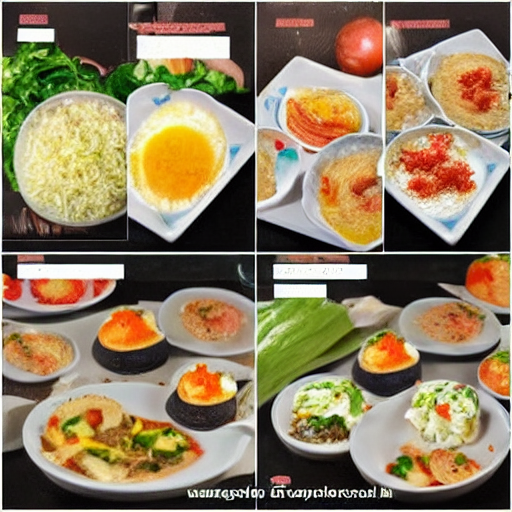

--------------------------------------------------------------------------------------------------------------


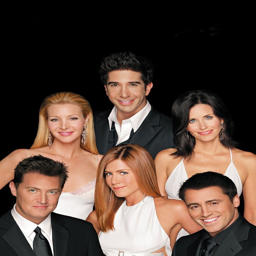

1/1 [==============================] - 0s 14ms/step
Predicted Class for output: Generate Both
:)
Answer: the cast of friendsis a popular American TV sitcom, based around six main characters: Ross Geller,
Rachel Green, Chandler Bing, Monica Geller, Joey Tribbiani and Phoebe Buffay.
Set in Manhattan, New York, the show follows these characters as they navigate
life and love in the urban city. Each character experiences different things
throughout the series, and use their own unique personalities to overcome their
comedy of errors. These six characters, supported by an array of eccentric
relatives and friends, make for a


100%|██████████| 50/50 [00:06<00:00,  7.92it/s]


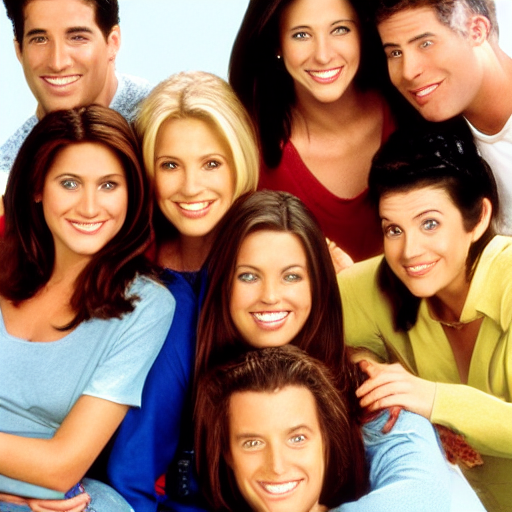

--------------------------------------------------------------------------------------------------------------
Prompt: Thank you
1/1 [==============================] - 0s 16ms/step
Predicted Class for output: Generate Image


100%|██████████| 50/50 [00:06<00:00,  7.78it/s]


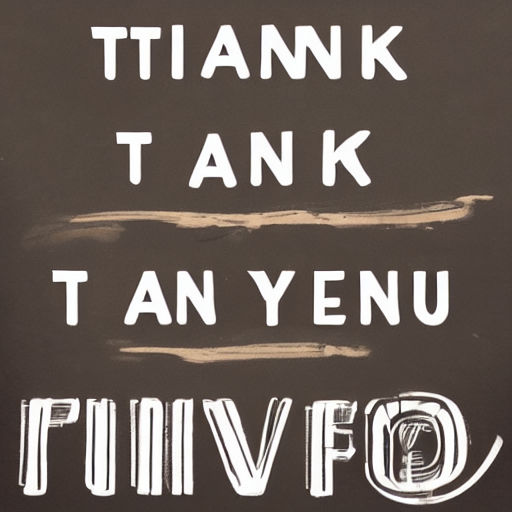

--------------------------------------------------------------------------------------------------------------
Exiting the program.


In [30]:
import tkinter as tk
from tkinter import simpledialog, filedialog
from PIL import Image
import openai  # Assuming you're using OpenAI's GPT models
from tkinter import Label, Entry, Button, Toplevel
import tkinter as tk
from tkinter import Text, Button
import textwrap


def handle_text_input(root):
    def on_submit():
        global input_text
        input_text = text_box.get("1.0", 'end-1c')
        dialog.destroy()

    dialog = Toplevel(root)
    dialog.title("Input")

    text_box = Text(dialog, wrap='word', font=('Arial', 20), height=5, width=50)
    text_box.pack(padx=10, pady=10)

    submit_button = Button(dialog, text="Submit", command=on_submit)
    submit_button.pack(pady=5)

    dialog.grab_set()
    dialog.wait_window()
    wrapped_text = textwrap.fill("Prompt: " + input_text + "\n", width=80)
    print(wrapped_text)
    return input_text

def handle_image_input(root):
    image_path = filedialog.askopenfilename(parent=root, title="Select an Image", filetypes=[("Image Files", "*.png;*.jpg;*.jpeg;*.bmp;*.gif")])

    if image_path:
        try:
            image = Image.open(image_path).convert('RGB')
            resized_image = image.resize((256, 256))
            # resized_image.show()
            display(resized_image)
            return image
        except IOError:
            print("Could not read the image. Please check the file path.")
    return None

def handle_both_input(root):
    text_output = handle_text_input(root)
    image_output = handle_image_input(root)
    return text_output, image_output

# Global variable for conversation history
conversation_history = []

def generate_text(input_text, history):
    global conversation_history
    openai.api_key = ""
    try:
        full_prompt = "\n".join(history) + "\n" + input_text
        response = openai.Completion.create(
          engine="text-davinci-003",
          prompt=full_prompt,
          max_tokens=100
        )
        generated_text = response.choices[0].text.strip()
        wrapped_text = textwrap.fill(generated_text, width=80)  # Wrap text to 80 characters
        conversation_history.extend([input_text, wrapped_text])
        print(":)")
        return wrapped_text
    except Exception as e:
        print(f"An error occurred: {e}")
        return ""

def generate_text_from_image(image, prompt):
    if prompt:
        inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
        generated_ids = model.generate(**inputs, max_new_tokens=20)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        return generated_text

    else:
        inputs = processor(image, return_tensors="pt").to(device, torch.float16)
        generated_ids = model.generate(**inputs, max_new_tokens=20)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        return generated_text
    
        
def generate_image(prompt):
    pipe.enable_attention_slicing()
    image = pipe(prompt).images[0]
    display(image)
    return image

def random_output_decision(text_input, resized_image, model, tokenizer, label_encoder, max_length):
    global conversation_history
    
    # Predict the output format using the classifier
    predicted_class = predict_class(text_input if text_input else "Default text", model, tokenizer, label_encoder, max_length)
    print("Predicted Class for output:", predicted_class)

    decision = predicted_class  # 'text', 'image', or 'both'


    if decision == 'Generate Text':
        if resized_image is None:
            # Concatenate history and text_input into a single string
            full_text_input = "/n".join(conversation_history) + "/nQuestion: " + (text_input or "Default text") + " Answer:"
            text2 = ''
            print(generate_text(full_text_input, conversation_history))
            
        elif text_input == None:
            value = generate_text_from_image(resized_image, None)
            text2 = generate_text_from_image(resized_image, "this is a image of")
            text1 = str("Correct the answer by adding more details. Give me complete answer." + str(text_input) + " This is a image of" + str(text2) + str(value))
            value_exp = generate_text(text1, conversation_history)
            print("Answer: " +  value + value_exp)

        else:
            value = generate_text_from_image(resized_image, text_input)
            text2 = generate_text_from_image(resized_image, "this is a image of")
            text1 = str("Correct the answer by adding more details. Give me complete answer." + str(text_input) + " This is a image of" + str(text2) + str(value))
            value_exp = generate_text(text1, conversation_history)
            print("Answer: " +  value + value_exp)
        

    elif decision == 'Generate Image':
        history_str = "/n".join(conversation_history)

        if resized_image == None:
            # value = generate_text(text_input if text_input is not None else "Default text")
            value = text_input

        elif text_input == None:
            value = generate_text_from_image(resized_image, None)

        else:
            value = generate_text_from_image(resized_image, text_input)

        image_output = generate_image(value)


    elif decision == 'Generate Both':
        history_str = "/n".join(conversation_history)
        
        if resized_image is None:
            value = generate_text(text_input if text_input is not None else "Default text", conversation_history)
            text2 = "Stable diffusion has created the image."

        elif text_input is None:
            value = generate_text_from_image(resized_image, None)
            text2 = generate_text_from_image(resized_image, "this is a image of")

        else:
            value = generate_text_from_image(resized_image, text_input)
            text2 = generate_text_from_image(resized_image, "this is a image of")

        
        text1 = "Correct the answer by adding more details. Give me complete answer. " + str(text_input) + " " + str(text2) + " " + str(value)
        value_exp = generate_text(text1, conversation_history)
        print("Answer: " + value + value_exp)
        input_comb = "Description: " + str(value) + str(value_exp)
        image_output = generate_image(input_comb[:77])

def get_user_choice(root):
    def on_submit():
        nonlocal user_choice
        user_choice = entry.get()
        dialog.destroy()

    user_choice = None
    dialog = Toplevel(root)
    dialog.title("Input")

    Label(dialog, text="Enter 'text input' for text Input, 'image input' for Image Input, 'both input' for both, or 'exit' to quit:", font=('Arial', 12)).pack(padx=10, pady=10)

    entry = Entry(dialog, font=('Arial', 22), width=50)
    entry.pack(padx=10, pady=10)

    submit_button = Button(dialog, text="Submit", command=on_submit)
    submit_button.pack(pady=5)

    dialog.grab_set()  # Make the dialog modal
    dialog.wait_window()  # Wait for the dialog to be closed

    return user_choice.lower() if user_choice else None


def main():
    # Load the model and components
    model1, tokenizer, label_encoder = load_classifier_model()
    max_length = 150

    root = tk.Tk()
    root.withdraw()  # Hide the main window

    try:
        while True:
            print("--------------------------------------------------------------------------------------------------------------")
            choice = get_user_choice(root)

            if not choice or choice == 'exit':
                print("Exiting the program.")
                break

            elif choice == 'text input':
                text_output = handle_text_input(root)
                random_output_decision(text_output, None, model1, tokenizer, label_encoder, max_length)

            elif choice == 'image input':
                image = handle_image_input(root)
                if image is not None:
                    random_output_decision(None, image, model1, tokenizer, label_encoder, max_length)

            elif choice == 'both input':
                text_input, image = handle_both_input(root)
                if text_input is not None and image is not None:
                    random_output_decision(text_input, image, model1, tokenizer, label_encoder, max_length)

            else:
                print("Invalid Input. Please choose 'text input', 'image input', 'both input', or 'exit'.")

    finally:
        root.destroy()
        del model1
        del tokenizer
        del label_encoder
        conversation_history = []
        import gc
        gc.collect()

if __name__ == "__main__":
    main()